In [1]:
# %%writefile xxx.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import numpy as np
import pandas as pd

import QUANTAXIS as QA

import tools.Sample_Tools as smpl
from base.JuUnits import parallal_task,task_chunk_split
from base.JuUnits import excute_for_multidates

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [273]:
# constance




In [328]:

def get_RSJ_by_code(code,st='2016-01-04',en='2020-12-31',fr=QA.FREQUENCE.FIVE_MIN):
    def calc_rv(varaint_daily):
        ret = (varaint_daily/varaint_daily.shift(1) - 1).dropna()
        r_2 = np.power(ret,2)
        #已实现方差
        rv = r_2.sum()
        
        if rv==0:
            return 0,0,0

        #好波
        rv_up = r_2[ret>0].sum()
        #坏波
        rv_down = r_2[ret<0].sum()

        # 有符号跳跃方差
        sj = rv_up - rv_down
        # 相对有符号的跳跃方差,
        rsj = sj / rv

        n = len(ret)
        # 已实现的偏度（RSK）
        rsk = (np.power(n,0.5) * np.power(ret,3).sum()) / np.power(rv,3.0/2.0)
        # 已实现的峰度（RKT）
        rkt = (n * np.power(ret,4).sum()) / np.power(rv,2)
        return rsj,rsk,rkt

    stock_df = smpl.get_data(code, start=st, end=en, gap=None, freq=fr)
    if stock_df is None:
        return None
    stock_df = stock_df.data
    var = stock_df.close
    var_unindex = var.reset_index()

    res = var_unindex[var.name].groupby(var_unindex.datetime.dt.to_period("D"),group_keys=False).apply(lambda x: calc_rv(x))
    res_df = pd.DataFrame(res.to_list(),index=pd.MultiIndex.from_arrays([res.index.to_timestamp(),[code]*len(res.index)]),columns=['rsj','rsk','rkt'])
    
    return res_df

df_tmp = pd.DataFrame()
for code in ['000001','000002']:
    res = get_RSJ_by_code(code)
    if res is None:
        continue
    df_tmp = pd.concat([df_tmp,res],axis=0)


In [3]:
codes = smpl.get_codes_by_market(sse='all',only_main=True,filter_st=True)
# codes = codes[0:14]

worker=8
task = task_chunk_split(codes, worker)

results = parallal_task(worker, multi_test, task)


Now in the main code. Process name is: base.JuUnits
base.JuUnits, subpid:13352  pid:9696


  0%|          | 0/8 [00:00<?, ?it/s]

In [2]:
def multi_test(codes):
    import numpy as np
    import pandas as pd
    import QUANTAXIS as QA
    import tools.Sample_Tools as smpl

    
    def get_RSJ_by_codex(code,st='2016-01-04',en='2020-12-31',fr=QA.FREQUENCE.FIVE_MIN):
        def calc_rvx(varaint_daily):
            ret = (varaint_daily/varaint_daily.shift(1) - 1).dropna()
            r_2 = np.power(ret,2)
            #已实现方差
            rv = r_2.sum()

            if rv==0:
                return 0,0,0

            #好波
            rv_up = r_2[ret>0].sum()
            #坏波
            rv_down = r_2[ret<0].sum()

            # 有符号跳跃方差
            sj = rv_up - rv_down
            # 相对有符号的跳跃方差,
            rsj = sj / rv

            n = len(ret)
            # 已实现的偏度（RSK）
            rsk = (np.power(n,0.5) * np.power(ret,3).sum()) / np.power(rv,3.0/2.0)
            # 已实现的峰度（RKT）
            rkt = (n * np.power(ret,4).sum()) / np.power(rv,2)
            return rsj,rsk,rkt

        stock_df = smpl.get_data(code, start=st, end=en, gap=None, freq=fr)
        if stock_df is None:
            return None
        stock_df = stock_df.data
        
        var = stock_df.close
        var_unindex = var.reset_index()

        res = var_unindex[var.name].groupby(var_unindex.datetime.dt.to_period("D"),group_keys=False).apply(lambda x: calc_rvx(x))
        res_df = pd.DataFrame(res.to_list(),index=pd.MultiIndex.from_arrays([res.index.to_timestamp(),[code]*len(res.index)]),columns=['rsj','rsk','rkt'])

        return res_df

    df_tmp = pd.DataFrame()
    for code in codes:
        res = get_RSJ_by_codex(code)
        if res is None:
            continue
        df_tmp = pd.concat([df_tmp,res],axis=0)
    return df_tmp

In [50]:
# res_final_df = pd.concat(results).sort_index()
# res_final_df.index.names = ['date', 'code']
# res_final_df.index=pd.MultiIndex.from_arrays([res_final_df.index.get_level_values(0).to_timestamp(),res_final_df.index.get_level_values(1)])

In [26]:
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

tail = False
if tail:
    file = 'all_tail_qfq'
else:
    file = 'all_train_qfq'
    
df_all = load_cache(file,cache_type=CACHE_TYPE.STOCK).sort_index()
smpl.optimize_data_type(df_all)

data_ = df_all

year1 = '2016'
year2 = '2020'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()


ret = smpl.get_forward_return(data_,'close')
ret.name = 'ret_forward'
ret[np.abs(ret)>0.15]=np.nan

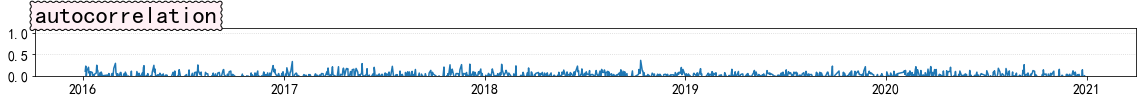

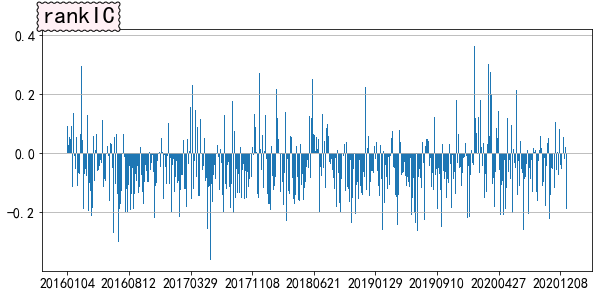

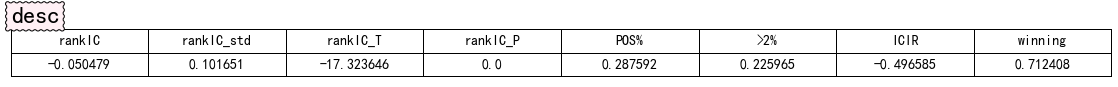

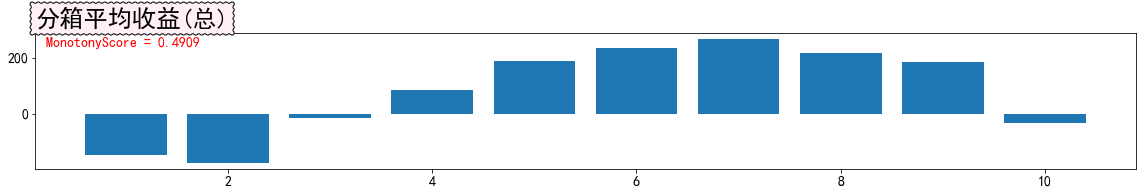

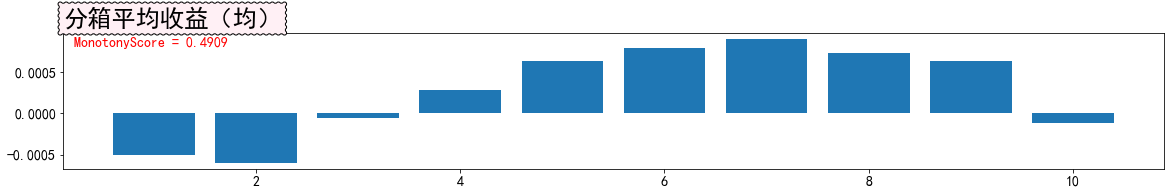

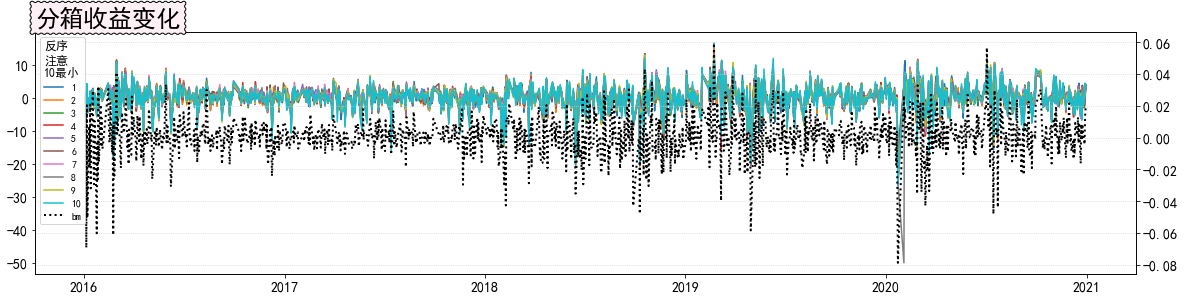

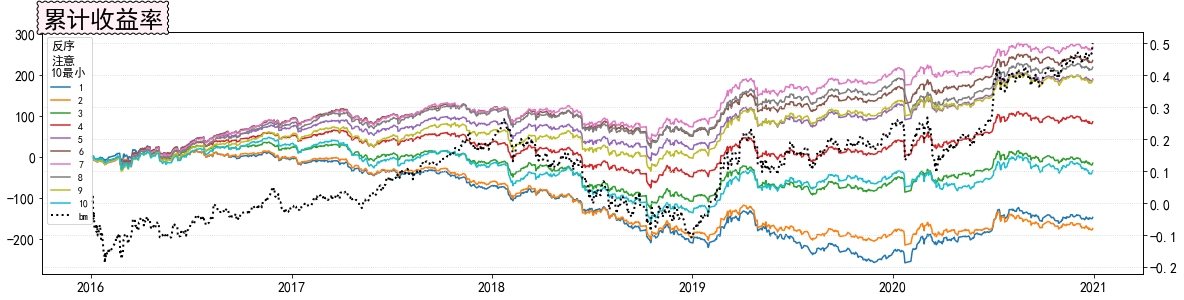

Wall time: 22.8 s


In [53]:
%%time
from tools.Test_Tools_Simple import FactorTest

# %load_ext autoreload
# %autoreload 1
# %aimport tools.Test_Tools_Simple

fa = pd.DataFrame(res_final_df['rsj']).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()

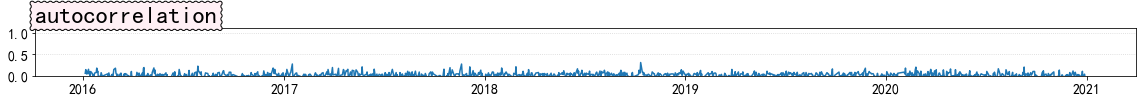

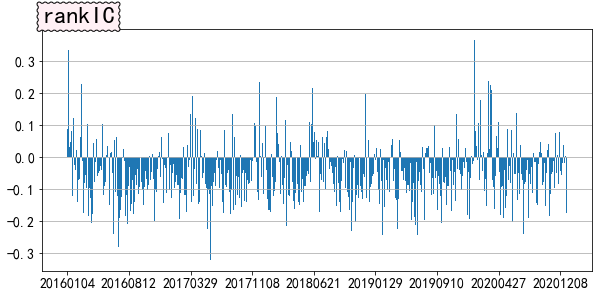

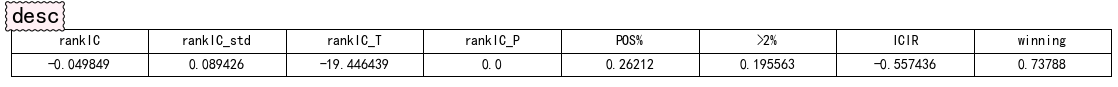

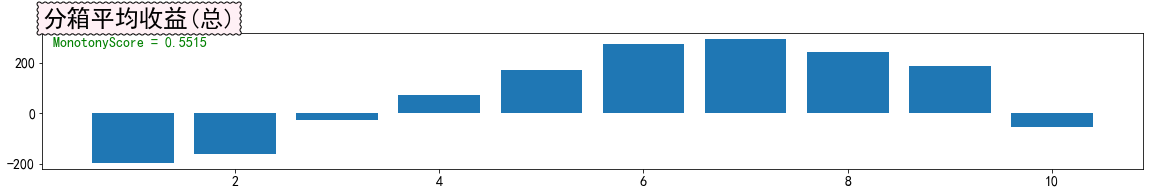

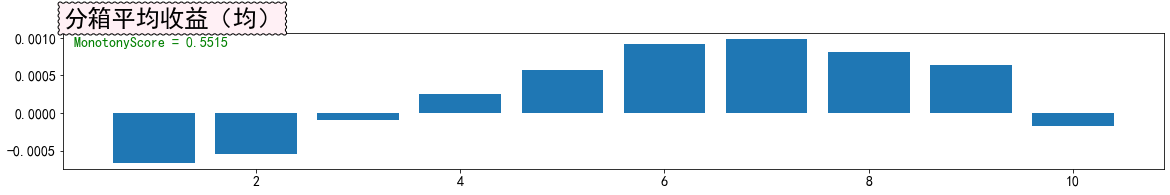

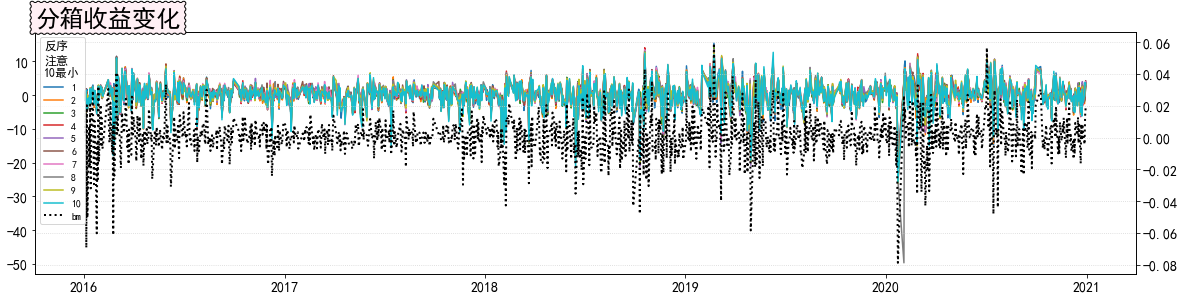

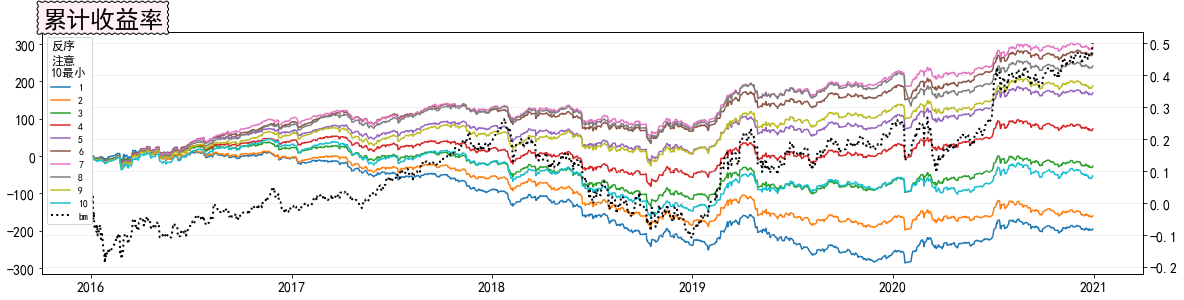

In [54]:
fa = pd.DataFrame(res_final_df['rsk']).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()

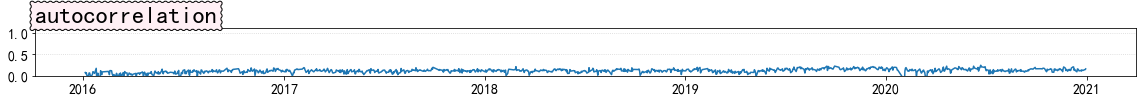

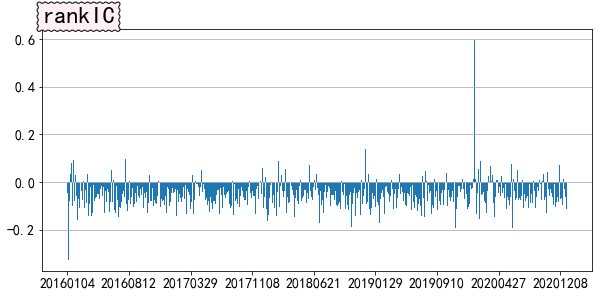

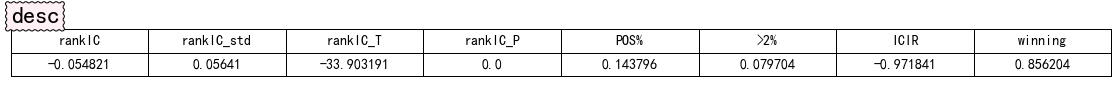

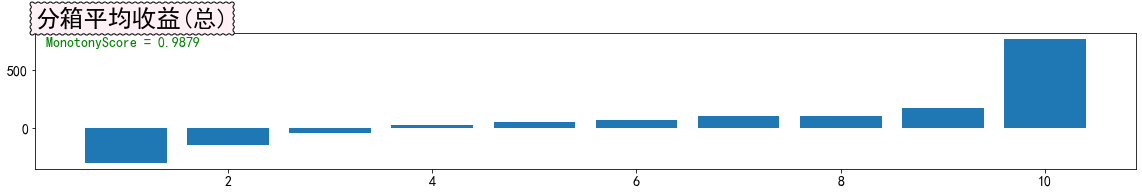

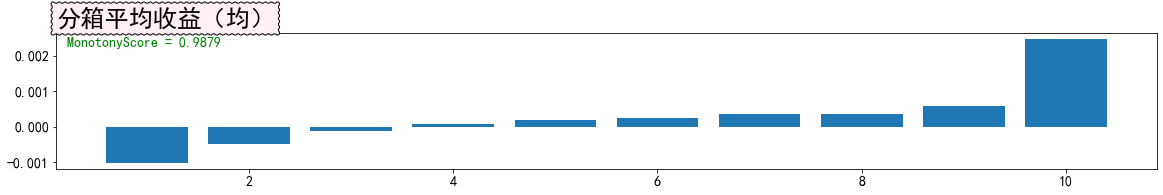

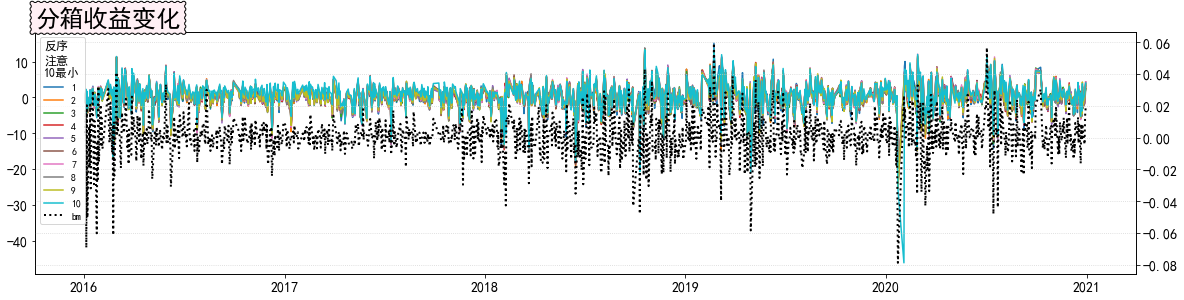

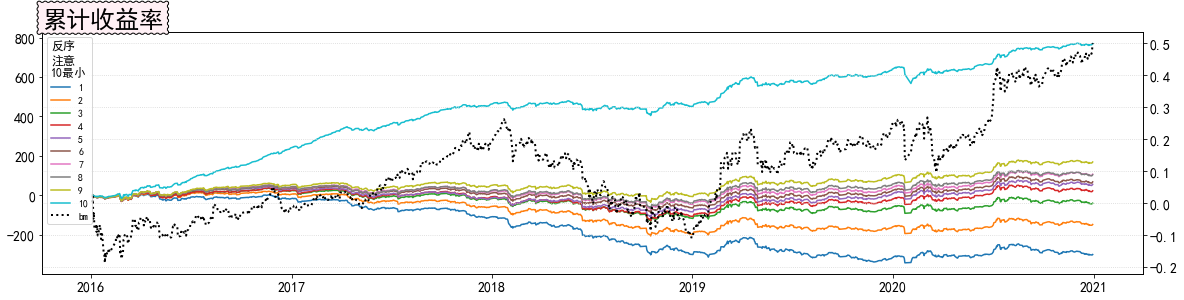

In [55]:
fa = pd.DataFrame(res_final_df['rkt']).dropna()
fa.columns=['xxx']
test = FactorTest(start=dates.min().strftime('%Y-%m-%d'),end=dates.max().strftime('%Y-%m-%d'),target_field='xxx',blenchmark_name='沪深300', freq="d")
test.process_ind_simple(fa,ret,need_descript=True)
test.plot()